In [1]:
#ERP5 Investment strategy

#Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from datetime import datetime, timedelta
from tqdm import tqdm
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

In [2]:
# Load Large Cap Stocks CSV data into a DataFrame
file_path = 'stock_data_LC.CSV'
result_df = pd.read_csv(file_path)
result_df = result_df.dropna()

# Display the DataFrame
result_df

S.No.           Name  enterpriseValue     ebidt      ebit  netProfit  \
0       1         ABB.NS        157759.11   1802.75   1962.37    1456.45   
1       2  ADANIENSOL.NS        143888.73   6181.93   4405.85    1195.61   
2       3    ADANIENT.NS        393535.30  12938.27   9896.12    3335.27   
3       4  ADANIPORTS.NS        311146.61  17079.94  13191.48    8103.99   
4       5        ATGL.NS        101000.72   1165.64   1007.76     667.50   
..    ...            ...              ...       ...       ...        ...   
95     96         VBL.NS        188654.26   3795.75   3180.95    2211.22   
96     97        VEDL.NS        223937.27  37748.00  27025.00    7539.00   
97     98       WIPRO.NS        236621.06  19383.30  15976.20   11112.10   
98     99      ZOMATO.NS        152021.51    889.00    363.00     351.00   
99    100   ZYDUSLIFE.NS        100684.74   5668.40   4904.30    3972.80   

    freeCashFlow  cashFlowOperations  cashFlowInvesting     assets  ...  \
0        1168.40             1351.48           -3352.01   11001.19  ...   
1         608.08             6037.62           -4942.96   58538.38  ...   
2      -11934.07            10312.19          -18766.65  160586.24  ...   
3        7627.99            15017.58           -6767.56  116999.20  ...   
4         155.89              955.13            -752.28    6591.86  ...   
..           ...                 ...                ...        ...  ...   
95       -803.14             2390.78           -3287.80   15187.18  ...   
96      19097.00            35654.00          -13686.00  190807.00  ...   
97      16972.80            17621.60            1168.00  114790.60  ...   
98        444.00              646.00            -347.00   23356.00  ...   
99       2345.00             3227.90           -1475.20   29280.80  ...   

    pitroski  freeCashFlow5Yrs  roce5Yrs   ebitdYield  earningsYield  \
0          9           3026.72     18.23  0.011427232    0.012439028   
1          7           2095.15     10.19  0.042963268    0.030619841   
2          6         -18806.36      8.58  0.032877025    0.025146715   
3          8          26415.86     11.77  0.054893544    0.042396348   
4          8           -286.87     26.51  0.011540908    0.009977751   
..       ...               ...       ...          ...            ...   
95         7            703.86     20.31  0.020120139    0.016861268   
96         5          92059.00     20.10  0.168565063    0.120681118   
97         8          58456.30     19.54  0.081917053    0.067518081   
98         7          -4444.88    -32.77  0.005847857     0.00238782   
99         7           9581.90     15.22  0.056298502    0.048709467   

        fcfYield  liquidity  fcfToDebt     accrualCF  fcf5YrsYield  
0    0.007406228   0.003997  23.854635   0.314236914   0.019185707  
1    0.004226043   0.000406   0.016404    0.00172451   0.014560904  
2   -0.030325285   0.000971  -0.182729   0.073416813  -0.047788242  
3    0.024515742   0.001323   0.155146  -0.001248128   0.084898434  
4    0.001543454   0.000270   0.100106   0.070488451  -0.002840277  
..           ...        ...        ...           ...           ...  
95  -0.004257206   0.001010  -0.147872    0.20466209   0.003730952  
96   0.085278346   0.000548   0.262426  -0.075620915   0.411092803  
97   0.071729879   0.001581   1.030847  -0.066882654   0.247046058  
98   0.002920639   0.000005   0.592790   0.002226409  -0.029238494  
99    0.02329052   0.002915   2.915941   0.075821016   0.095167351  

[100 rows x 25 columns]

In [3]:
# Define whether higher or lower values are better for the ratio
higher_is_better = {
    'roic': True,
}

# Calculate percentiles for the ratio
for ratio, is_higher_better in higher_is_better.items():
    result_df[f'{ratio} Percentile'] = result_df[ratio].rank(pct=True, ascending=is_higher_better) * 100

# Calculate Composite Score of the ratio
percentile_columns = [f'{ratio} Percentile' for ratio in higher_is_better.keys()]
result_df['Composite Score_roic'] = result_df[percentile_columns].mean(axis=1)

# Rank companies based on Composite Score
result_df['Rank_roic'] = result_df['Composite Score_roic'].rank(ascending=False).astype(int)

result_df

S.No.           Name  enterpriseValue     ebidt      ebit  netProfit  \
0       1         ABB.NS        157759.11   1802.75   1962.37    1456.45   
1       2  ADANIENSOL.NS        143888.73   6181.93   4405.85    1195.61   
2       3    ADANIENT.NS        393535.30  12938.27   9896.12    3335.27   
3       4  ADANIPORTS.NS        311146.61  17079.94  13191.48    8103.99   
4       5        ATGL.NS        101000.72   1165.64   1007.76     667.50   
..    ...            ...              ...       ...       ...        ...   
95     96         VBL.NS        188654.26   3795.75   3180.95    2211.22   
96     97        VEDL.NS        223937.27  37748.00  27025.00    7539.00   
97     98       WIPRO.NS        236621.06  19383.30  15976.20   11112.10   
98     99      ZOMATO.NS        152021.51    889.00    363.00     351.00   
99    100   ZYDUSLIFE.NS        100684.74   5668.40   4904.30    3972.80   

    freeCashFlow  cashFlowOperations  cashFlowInvesting     assets  ...  \
0        1168.40             1351.48           -3352.01   11001.19  ...   
1         608.08             6037.62           -4942.96   58538.38  ...   
2      -11934.07            10312.19          -18766.65  160586.24  ...   
3        7627.99            15017.58           -6767.56  116999.20  ...   
4         155.89              955.13            -752.28    6591.86  ...   
..           ...                 ...                ...        ...  ...   
95       -803.14             2390.78           -3287.80   15187.18  ...   
96      19097.00            35654.00          -13686.00  190807.00  ...   
97      16972.80            17621.60            1168.00  114790.60  ...   
98        444.00              646.00            -347.00   23356.00  ...   
99       2345.00             3227.90           -1475.20   29280.80  ...   

     ebitdYield  earningsYield      fcfYield  liquidity  fcfToDebt  \
0   0.011427232    0.012439028   0.007406228   0.003997  23.854635   
1   0.042963268    0.030619841   0.004226043   0.000406   0.016404   
2   0.032877025    0.025146715  -0.030325285   0.000971  -0.182729   
3   0.054893544    0.042396348   0.024515742   0.001323   0.155146   
4   0.011540908    0.009977751   0.001543454   0.000270   0.100106   
..          ...            ...           ...        ...        ...   
95  0.020120139    0.016861268  -0.004257206   0.001010  -0.147872   
96  0.168565063    0.120681118   0.085278346   0.000548   0.262426   
97  0.081917053    0.067518081   0.071729879   0.001581   1.030847   
98  0.005847857     0.00238782   0.002920639   0.000005   0.592790   
99  0.056298502    0.048709467    0.02329052   0.002915   2.915941   

       accrualCF  fcf5YrsYield  roic Percentile Composite Score_roic Rank_roic  
0    0.314236914   0.019185707             72.0                 72.0        29  
1     0.00172451   0.014560904             11.0                 11.0        90  
2    0.073416813  -0.047788242             24.0                 24.0        77  
3   -0.001248128   0.084898434             45.0                 45.0        56  
4    0.070488451  -0.002840277             73.0                 73.0        28  
..           ...           ...              ...                  ...       ...  
95    0.20466209   0.003730952             71.0                 71.0        30  
96  -0.075620915   0.411092803             25.0                 25.0        76  
97  -0.066882654   0.247046058             43.0                 43.0        58  
98   0.002226409  -0.029238494              4.0                  4.0        97  
99   0.075821016   0.095167351             59.0                 59.0        42  

[100 rows x 28 columns]

In [4]:
# Define whether higher or lower values are better for the ratio
higher_is_better = {
    'priceToBook': False,
}

# Calculate percentiles for the ratio
for ratio, is_higher_better in higher_is_better.items():
    result_df[f'{ratio} Percentile'] = result_df[ratio].rank(pct=True, ascending=is_higher_better) * 100

# Calculate Composite Score of the ratio
percentile_columns = [f'{ratio} Percentile' for ratio in higher_is_better.keys()]
result_df['Composite Score_ptb'] = result_df[percentile_columns].mean(axis=1)

# Rank companies based on Composite Score
result_df['Rank_ptb'] = result_df['Composite Score_ptb'].rank(ascending=False).astype(int)

result_df

S.No.           Name  enterpriseValue     ebidt      ebit  netProfit  \
0       1         ABB.NS        157759.11   1802.75   1962.37    1456.45   
1       2  ADANIENSOL.NS        143888.73   6181.93   4405.85    1195.61   
2       3    ADANIENT.NS        393535.30  12938.27   9896.12    3335.27   
3       4  ADANIPORTS.NS        311146.61  17079.94  13191.48    8103.99   
4       5        ATGL.NS        101000.72   1165.64   1007.76     667.50   
..    ...            ...              ...       ...       ...        ...   
95     96         VBL.NS        188654.26   3795.75   3180.95    2211.22   
96     97        VEDL.NS        223937.27  37748.00  27025.00    7539.00   
97     98       WIPRO.NS        236621.06  19383.30  15976.20   11112.10   
98     99      ZOMATO.NS        152021.51    889.00    363.00     351.00   
99    100   ZYDUSLIFE.NS        100684.74   5668.40   4904.30    3972.80   

    freeCashFlow  cashFlowOperations  cashFlowInvesting     assets  ...  \
0        1168.40             1351.48           -3352.01   11001.19  ...   
1         608.08             6037.62           -4942.96   58538.38  ...   
2      -11934.07            10312.19          -18766.65  160586.24  ...   
3        7627.99            15017.58           -6767.56  116999.20  ...   
4         155.89              955.13            -752.28    6591.86  ...   
..           ...                 ...                ...        ...  ...   
95       -803.14             2390.78           -3287.80   15187.18  ...   
96      19097.00            35654.00          -13686.00  190807.00  ...   
97      16972.80            17621.60            1168.00  114790.60  ...   
98        444.00              646.00            -347.00   23356.00  ...   
99       2345.00             3227.90           -1475.20   29280.80  ...   

    liquidity  fcfToDebt     accrualCF  fcf5YrsYield  roic Percentile  \
0    0.003997  23.854635   0.314236914   0.019185707             72.0   
1    0.000406   0.016404    0.00172451   0.014560904             11.0   
2    0.000971  -0.182729   0.073416813  -0.047788242             24.0   
3    0.001323   0.155146  -0.001248128   0.084898434             45.0   
4    0.000270   0.100106   0.070488451  -0.002840277             73.0   
..        ...        ...           ...           ...              ...   
95   0.001010  -0.147872    0.20466209   0.003730952             71.0   
96   0.000548   0.262426  -0.075620915   0.411092803             25.0   
97   0.001581   1.030847  -0.066882654   0.247046058             43.0   
98   0.000005   0.592790   0.002226409  -0.029238494              4.0   
99   0.002915   2.915941   0.075821016   0.095167351             59.0   

    Composite Score_roic  Rank_roic  priceToBook Percentile  \
0                   72.0         29                     9.0   
1                   11.0         90                    32.0   
2                   24.0         77                    33.0   
3                   45.0         56                    56.0   
4                   73.0         28                     8.0   
..                   ...        ...                     ...   
95                  71.0         30                    10.0   
96                  25.0         76                    58.0   
97                  43.0         58                    75.0   
98                   4.0         97                    36.0   
99                  59.0         42                    57.0   

   Composite Score_ptb Rank_ptb  
0                  9.0       92  
1                 32.0       69  
2                 33.0       68  
3                 56.0       45  
4                  8.0       93  
..                 ...      ...  
95                10.0       91  
96                58.0       43  
97                75.0       26  
98                36.0       65  
99                57.0       44  

[100 rows x 31 columns]

In [5]:
# Define whether higher or lower values are better for the ratio
higher_is_better = {
    'earningsYield': True,
}

# Calculate percentiles for the ratio
for ratio, is_higher_better in higher_is_better.items():
    result_df[f'{ratio} Percentile'] = result_df[ratio].rank(pct=True, ascending=is_higher_better) * 100

# Calculate Composite Score of the ratio
percentile_columns = [f'{ratio} Percentile' for ratio in higher_is_better.keys()]
result_df['Composite Score_ey'] = result_df[percentile_columns].mean(axis=1)

# Rank companies based on Composite Score
result_df['Rank_ey'] = result_df['Composite Score_ey'].rank(ascending=False).astype(int)

result_df

S.No.           Name  enterpriseValue     ebidt      ebit  netProfit  \
0       1         ABB.NS        157759.11   1802.75   1962.37    1456.45   
1       2  ADANIENSOL.NS        143888.73   6181.93   4405.85    1195.61   
2       3    ADANIENT.NS        393535.30  12938.27   9896.12    3335.27   
3       4  ADANIPORTS.NS        311146.61  17079.94  13191.48    8103.99   
4       5        ATGL.NS        101000.72   1165.64   1007.76     667.50   
..    ...            ...              ...       ...       ...        ...   
95     96         VBL.NS        188654.26   3795.75   3180.95    2211.22   
96     97        VEDL.NS        223937.27  37748.00  27025.00    7539.00   
97     98       WIPRO.NS        236621.06  19383.30  15976.20   11112.10   
98     99      ZOMATO.NS        152021.51    889.00    363.00     351.00   
99    100   ZYDUSLIFE.NS        100684.74   5668.40   4904.30    3972.80   

    freeCashFlow  cashFlowOperations  cashFlowInvesting     assets  ...  \
0        1168.40             1351.48           -3352.01   11001.19  ...   
1         608.08             6037.62           -4942.96   58538.38  ...   
2      -11934.07            10312.19          -18766.65  160586.24  ...   
3        7627.99            15017.58           -6767.56  116999.20  ...   
4         155.89              955.13            -752.28    6591.86  ...   
..           ...                 ...                ...        ...  ...   
95       -803.14             2390.78           -3287.80   15187.18  ...   
96      19097.00            35654.00          -13686.00  190807.00  ...   
97      16972.80            17621.60            1168.00  114790.60  ...   
98        444.00              646.00            -347.00   23356.00  ...   
99       2345.00             3227.90           -1475.20   29280.80  ...   

    fcf5YrsYield  roic Percentile  Composite Score_roic  Rank_roic  \
0    0.019185707             72.0                  72.0         29   
1    0.014560904             11.0                  11.0         90   
2   -0.047788242             24.0                  24.0         77   
3    0.084898434             45.0                  45.0         56   
4   -0.002840277             73.0                  73.0         28   
..           ...              ...                   ...        ...   
95   0.003730952             71.0                  71.0         30   
96   0.411092803             25.0                  25.0         76   
97   0.247046058             43.0                  43.0         58   
98  -0.029238494              4.0                   4.0         97   
99   0.095167351             59.0                  59.0         42   

    priceToBook Percentile  Composite Score_ptb  Rank_ptb  \
0                      9.0                  9.0        92   
1                     32.0                 32.0        69   
2                     33.0                 33.0        68   
3                     56.0                 56.0        45   
4                      8.0                  8.0        93   
..                     ...                  ...       ...   
95                    10.0                 10.0        91   
96                    58.0                 58.0        43   
97                    75.0                 75.0        26   
98                    36.0                 36.0        65   
99                    57.0                 57.0        44   

    earningsYield Percentile Composite Score_ey Rank_ey  
0                        7.0                7.0      94  
1                       39.0               39.0      62  
2                       30.0               30.0      71  
3                       49.0               49.0      52  
4                        5.0                5.0      96  
..                       ...                ...     ...  
95                      15.0               15.0      86  
96                      96.0               96.0       5  
97                      76.0               76.0      25  
98                       2.0        

In [6]:
# Define whether higher or lower values are better for the ratio
higher_is_better = {
    'roce5Yrs': True,
}

# Calculate percentiles for the ratio
for ratio, is_higher_better in higher_is_better.items():
    result_df[f'{ratio} Percentile'] = result_df[ratio].rank(pct=True, ascending=is_higher_better) * 100

# Calculate Composite Score of ratio
percentile_columns = [f'{ratio} Percentile' for ratio in higher_is_better.keys()]
result_df['Composite Score_roce'] = result_df[percentile_columns].mean(axis=1)

# Rank companies based on Composite Score
result_df['Rank_roce'] = result_df['Composite Score_roce'].rank(ascending=False).astype(int)

result_df

S.No.           Name  enterpriseValue     ebidt      ebit  netProfit  \
0       1         ABB.NS        157759.11   1802.75   1962.37    1456.45   
1       2  ADANIENSOL.NS        143888.73   6181.93   4405.85    1195.61   
2       3    ADANIENT.NS        393535.30  12938.27   9896.12    3335.27   
3       4  ADANIPORTS.NS        311146.61  17079.94  13191.48    8103.99   
4       5        ATGL.NS        101000.72   1165.64   1007.76     667.50   
..    ...            ...              ...       ...       ...        ...   
95     96         VBL.NS        188654.26   3795.75   3180.95    2211.22   
96     97        VEDL.NS        223937.27  37748.00  27025.00    7539.00   
97     98       WIPRO.NS        236621.06  19383.30  15976.20   11112.10   
98     99      ZOMATO.NS        152021.51    889.00    363.00     351.00   
99    100   ZYDUSLIFE.NS        100684.74   5668.40   4904.30    3972.80   

    freeCashFlow  cashFlowOperations  cashFlowInvesting     assets  ...  \
0        1168.40             1351.48           -3352.01   11001.19  ...   
1         608.08             6037.62           -4942.96   58538.38  ...   
2      -11934.07            10312.19          -18766.65  160586.24  ...   
3        7627.99            15017.58           -6767.56  116999.20  ...   
4         155.89              955.13            -752.28    6591.86  ...   
..           ...                 ...                ...        ...  ...   
95       -803.14             2390.78           -3287.80   15187.18  ...   
96      19097.00            35654.00          -13686.00  190807.00  ...   
97      16972.80            17621.60            1168.00  114790.60  ...   
98        444.00              646.00            -347.00   23356.00  ...   
99       2345.00             3227.90           -1475.20   29280.80  ...   

    Rank_roic  priceToBook Percentile  Composite Score_ptb  Rank_ptb  \
0          29                     9.0                  9.0        92   
1          90                    32.0                 32.0        69   
2          77                    33.0                 33.0        68   
3          56                    56.0                 56.0        45   
4          28                     8.0                  8.0        93   
..        ...                     ...                  ...       ...   
95         30                    10.0                 10.0        91   
96         76                    58.0                 58.0        43   
97         58                    75.0                 75.0        26   
98         97                    36.0                 36.0        65   
99         42                    57.0                 57.0        44   

    earningsYield Percentile  Composite Score_ey  Rank_ey  \
0                        7.0                 7.0       94   
1                       39.0                39.0       62   
2                       30.0                30.0       71   
3                       49.0                49.0       52   
4                        5.0                 5.0       96   
..                       ...                 ...      ...   
95                      15.0                15.0       86   
96                      96.0                96.0        5   
97                      76.0                76.0       25   
98                       2.0                 2.0       99   
99                      56.0                56.0       45   

    roce5Yrs Percentile Composite Score_roce Rank_roce  
0                  61.0                 61.0        40  
1                  25.0                 25.0        76  
2                  16.0                 16.0        85  
3                  34.0                 34.0        67  
4                  81.0                 81.0        20  
..                  ...                  ...       ...  
95                 69.0                 69.0        32  
96                 68.0                 68.0        33  
97                 67.0                 67.0        34  
98                  1.

In [7]:
#Calculate the composite rank by summing up the individual ranks and sort the companies based on the composite rank
percentile_columns = result_df['Rank_ey'] + result_df['Rank_roic'] + result_df['Rank_roce'] + result_df['Rank_ptb']
result_df['Composite rank'] = percentile_columns
result_df = result_df.sort_values(by='Composite rank')
result_df.reset_index(drop=True, inplace=True)
result_df

S.No.           Name  enterpriseValue     ebidt      ebit  netProfit  \
0      26   COALINDIA.NS        248809.21  56367.40  49631.98   37369.13   
1      12  BAJAJ-AUTO.NS        174134.96  47382.29  40611.03   26858.84   
2      16  BANKBARODA.NS         88355.64   7528.53   7494.67    7364.91   
3      44   ICICIBANK.NS        347766.43  80979.55  65113.44   43161.15   
4      58        LICI.NS        543830.57  42879.90  42879.90   40884.77   
..    ...            ...              ...       ...       ...        ...   
95      3    ADANIENT.NS        393535.30  12938.27   9896.12    3335.27   
96     39    HDFCLIFE.NS        114338.15    977.28    977.28    1574.08   
97     82         TCS.NS        104682.38   2487.90   2110.75    1215.40   
98     30         DLF.NS        189281.98   2654.94   2506.99    2723.53   
99     99      ZOMATO.NS        152021.51    889.00    363.00     351.00   

    freeCashFlow  cashFlowOperations  cashFlowInvesting      assets  ...  \
0        1794.57            18103.10           -4485.80   237672.26  ...   
1       26606.03            35935.90          -10520.58   202417.75  ...   
2        1940.81             1941.12            -471.70    65161.08  ...   
3       34453.20            71098.63          -31463.75   482362.00  ...   
4       25408.93            26121.65          -25400.02  5316047.12  ...   
..           ...                 ...                ...         ...  ...   
95     -11934.07            10312.19          -18766.65   160586.24  ...   
96      10587.01            10721.35          -13616.71   302686.95  ...   
97       1626.45             1936.68           -1910.77    27878.79  ...   
98       3166.38             2538.82           -1528.68    60262.39  ...   
99        444.00              646.00            -347.00    23356.00  ...   

    priceToBook Percentile  Composite Score_ptb  Rank_ptb  \
0                     72.0                 72.0        29   
1                     90.0                 90.0        11   
2                     91.5                 91.5         9   
3                     98.0                 98.0         3   
4                     39.0                 39.0        62   
..                     ...                  ...       ...   
95                    33.0                 33.0        68   
96                    35.0                 35.0        66   
97                    44.0                 44.0        57   
98                    60.0                 60.0        41   
99                    36.0                 36.0        65   

    earningsYield Percentile  Composite Score_ey  Rank_ey  \
0                       98.0                98.0        3   
1                      100.0               100.0        1   
2                       91.0                91.0       10   
3                       97.0                97.0        4   
4                       87.0                87.0       14   
..                       ...                 ...      ...   
95                      30.0                30.0       71   
96                       3.0                 3.0       98   
97                      19.0                19.0       82   
98                       9.0                 9.0       92   
99                       2.0                 2.0       99   

    roce5Yrs Percentile  Composite Score_roce Rank_roce Composite rank  
0                  96.0                  96.0         5             55  
1                  55.0                  55.0        46             78  
2                  27.0                  27.0        74             94  
3                  40.0                  40.0        61            101  
4                  97.0                  97.0         4            105  
..                  ...                   ...       ...            ...  
95                 16.0                  16.0        85            301  
96                 48.0                  48.0        53            310  
97                 20.0                  20.0        81

In [8]:
# Select top 20% based on rank
top_20_percent = result_df.head(int(len(result_df) * 0.2))
top_20 = top_20_percent['Name']
top_20

0      COALINDIA.NS
1     BAJAJ-AUTO.NS
2     BANKBARODA.NS
3      ICICIBANK.NS
4           LICI.NS
5           ONGC.NS
6           GAIL.NS
7           INFY.NS
8        DRREDDY.NS
9        HCLTECH.NS
10           ITC.NS
11    HEROMOTOCO.NS
12     EICHERMOT.NS
13         WIPRO.NS
14     TATASTEEL.NS
15          LTIM.NS
16    BAJFINANCE.NS
17    MUTHOOTFIN.NS
18    TATACONSUM.NS
19        MARUTI.NS
Name: Name, dtype: object

In [9]:
#Backtest the strategy with the top 20 stocks

def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

def preprocess_data(data):
    data["Return_6months"] = (data["Adj Close"] / data["Adj Close"].shift(126) - 1) * 100
    data["Return_3months"] = (data["Adj Close"] / data["Adj Close"].shift(63) - 1) * 100
    data["Return_1month"] = (data["Adj Close"] / data["Adj Close"].shift(21) - 1) * 100
    data["Return_1week"] = (data["Adj Close"] / data["Adj Close"].shift(5) - 1) * 100
    data["Return_1day"] = (data["Adj Close"] / data["Adj Close"].shift(1) - 1) * 100
    
    return data

nifty50_data = {}
start_date = "2023-01-01"
end_date = "2024-05-31"

# Fetch Nifty50 data
for symbol in top_20:
    nifty50_data[symbol] = fetch_stock_data(symbol, start_date, end_date)

# trade data storage
trade_data = []

# Iterate over the stocks
for symbol, stock_data in nifty50_data.items():
    processed_data = preprocess_data(stock_data)

    # Check if there are enough data points
    if len(processed_data) < 2:
        print(f"Not enough data for {symbol}. Skipping...")
        continue

    # Buy shares on the start date
    initial_capital = 500000
    shares_bought = int(initial_capital / processed_data["Close"].iloc[0])
    trade_data.append({"Symbol": symbol, "Action": "Buy", "Buy Date": processed_data.index[0], "Price": processed_data["Close"].iloc[0], "Shares": shares_bought, "Capital": initial_capital, "Profit/Loss": 0, "Sell Date": None, "Days in Trade": 0})

    # Sell shares on the end date
    capital = shares_bought * processed_data["Close"].iloc[-1]
    profit_loss = capital - initial_capital
    trade_data[-1]["Sell Date"] = processed_data.index[-1]
    trade_data[-1]["Days in Trade"] = len(pd.bdate_range(trade_data[-1]["Buy Date"], trade_data[-1]["Sell Date"]))
    trade_data.append({"Symbol": symbol, "Action": "Sell", "Buy Date": None, "Sell Date": processed_data.index[-1], "Days in Trade": 0, "Price": processed_data["Close"].iloc[-1], "Shares": shares_bought, "Capital": capital, "Profit/Loss": profit_loss})


trade_df = pd.DataFrame(trade_data)
trade_df.to_csv("ERP5.csv", index=False)

# Calculate total initial capital and total final capital
total_initial_capital = trade_df[trade_df["Action"] == "Buy"]["Capital"].sum()
total_final_capital = total_initial_capital + trade_df[trade_df["Action"] == "Sell"]["Profit/Loss"].sum()

# Display the final capital, percentage return, and in-trade days for each stock
for symbol in nifty50_data.keys():
    final_capital = trade_df[(trade_df["Symbol"] == symbol) & (trade_df["Action"] == "Sell")]["Capital"].iloc[0]
    percentage_return = (final_capital - initial_capital) / initial_capital * 100
    in_trade_days = trade_df[(trade_df["Symbol"] == symbol) & (trade_df["Action"] == "Sell")]["Days in Trade"].iloc[0]
    print(f"Symbol: {symbol}, Final Capital: {final_capital:.2f}, Percentage Return: {percentage_return:.2f}%, In-Trade Days: {in_trade_days}")

# Define the symbol for Nifty50
nifty50_symbol = "^NSEI"

# Download Nifty50 historical data
nifty50_data = yf.download(nifty50_symbol, start=start_date, end=end_date)

# Calculate total return
start_value = nifty50_data["Adj Close"].iloc[0]
end_value = nifty50_data["Adj Close"].iloc[-1]
total_return = ((end_value / start_value) - 1) * 100

# Display the total percentage return across all stocks
total_percentage_return = (total_final_capital - total_initial_capital) / total_initial_capital * 100
print(f"Total Initial Capital: {total_initial_capital:.2f}")
print(f"Total Final Capital Across All Stocks: {total_final_capital:.2f}")
print(f"Total Percentage Return Across All Stocks: {total_percentage_return:.2f}%")
# Display the total return of Nifty50
print(f"Total Return of Nifty50: {total_return:.2f}%")

# trade data storage
y_trade_data = []
nifty_stocks = ["^NSEI"]    
# Iterate over the years
years = range(int(start_date[:4]), int(end_date[:4]))
for year in years:
    # Fetch stock data for each stock
    stock_data_dict = {}
    for symbol in top_20:
        stock_data_dict[symbol] = fetch_stock_data(symbol, f"{year}-01-01", f"{year}-12-31")

    #yearly returns
    yearly_returns = {}

    # Iterate over the stocks
    y_total_portfolio_value = 0
    y_total_initial_capital = 0
    for symbol, stock_data in stock_data_dict.items():
        # Check if there are enough data points
        if len(stock_data) < 2:
            print(f"Not enough data for {symbol} in {year}. Skipping...")
            continue

        # Buy shares on the start date
        y_initial_capital = 500000
        y_shares_bought = int(y_initial_capital / stock_data["Close"].iloc[0])
        y_capital = y_shares_bought * stock_data["Close"].iloc[-1]
        y_total_portfolio_value += y_capital
        y_total_initial_capital += y_initial_capital
   
    # Fetch stock data for each stock
    n_stock_data_dict = {}

    for symbol in nifty_stocks:
        n_stock_data_dict[symbol] = fetch_stock_data(symbol, f"{year}-01-01", f"{year}-12-31")

    # nifty yearly returns
    n_yearly_returns = {}

    # Iterate over the stocks
    n_total_portfolio_value = 0
    n_total_initial_capital = 0
    for symbol, stock_data in n_stock_data_dict.items():
        # Check if there are enough data points
        if len(stock_data) < 2:
            print(f"Not enough data for {symbol} in {year}. Skipping...")
            continue

        # Buy shares on the start date
        n_initial_capital = 500000
        n_shares_bought = int(n_initial_capital / stock_data["Close"].iloc[0])
        n_capital = n_shares_bought * stock_data["Close"].iloc[-1]
        n_total_portfolio_value += n_capital
        n_total_initial_capital += n_initial_capital

    # Append year and yearly return for the portfolio
    yearly_returns["Year"] = year
    yearly_returns["Nifty_50"] = ((n_total_portfolio_value - n_total_initial_capital) / n_total_initial_capital) * 100
    yearly_returns["Portfolio"] = ((y_total_portfolio_value - y_total_initial_capital) / y_total_initial_capital) * 100

    # Append yearly returns to trade data
    y_trade_data.append(yearly_returns)


y_trade_df = pd.DataFrame(y_trade_data)


# Calculate CAGR (Compound Annual Growth Rate)
start_year = int(start_date[:4])
end_year = int(end_date[:4])
years = end_year - start_year

# CAGR formula: ((final value / beginning value) ^ (1 / no of years)) - 1
cagr = ((total_final_capital / total_initial_capital) ** (1 / years)) - 1
print(f"CAGR (Compound Annual Growth Rate of Portfolio): {cagr:.2%}")

# Calculate and print Nifty CAGR
nifty_cagr = ((end_value / start_value) ** (1 / years)) - 1
print(f"CAGR (Compound Annual Growth Rate of Nifty): {nifty_cagr:.2%}")


#Display trade data
print(trade_df)
print(y_trade_df)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

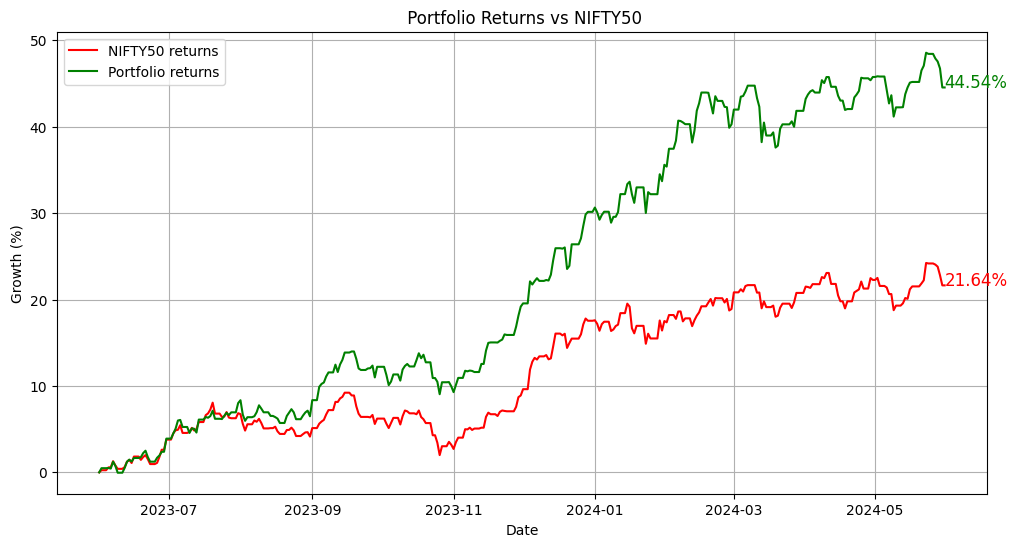

In [10]:
#Simulation of the portfolio returns vs NIFTY50
# Fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data['Adj Close']

# Initialize parameters
start_date = "2023-06-01"
end_date = "2024-05-31"
initial_capital = 500000

# Fetch historical stock data for the portfolio
portfolio_data = pd.DataFrame({ticker: fetch_stock_data(ticker, start_date, end_date) for ticker in top_20})

# Align all data to the same date range
portfolio_data = portfolio_data.reindex(pd.date_range(start=start_date, end=end_date)).ffill().bfill()

# Initialize portfolio value dataframe
portfolio_value_over_time = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date))
portfolio_value_over_time['Portfolio Value'] = 0

# Calculate the number of shares bought for each stock on the start date
shares_bought = {}
for ticker in top_20:
    shares_bought[ticker] = initial_capital / len(top_20) / portfolio_data[ticker].iloc[0]

# Calculate the daily portfolio value
for date in portfolio_value_over_time.index:
    daily_portfolio_value = 0
    for ticker in top_20:
        if date in portfolio_data.index:
            daily_portfolio_value += shares_bought[ticker] * portfolio_data[ticker].loc[date]
    portfolio_value_over_time.loc[date, 'Portfolio Value'] = daily_portfolio_value

# Handle NaN values
portfolio_value_over_time.dropna(inplace=True)

# Resample to ensure alignment
portfolio_value_over_time = portfolio_value_over_time.resample('D').ffill()
nifty_data = fetch_stock_data('^NSEI', start_date, end_date).resample('D').ffill()

# Calculate cumulative growth
nifty_growth = (nifty_data / nifty_data.iloc[0] - 1) * 100
portfolio_growth = (portfolio_value_over_time['Portfolio Value'] / portfolio_value_over_time['Portfolio Value'].iloc[0] - 1) * 100


# Ensure both growth data are aligned by reindexing
aligned_index = portfolio_growth.index.union(nifty_growth.index)
portfolio_growth = portfolio_growth.reindex(aligned_index).ffill()
nifty_growth = nifty_growth.reindex(aligned_index).ffill()

# Plotting the growth of the portfolio and NIFTY50
plt.figure(figsize=(12, 6))
plt.plot(nifty_growth.index, nifty_growth, label='NIFTY50 returns', color='red')
plt.plot(portfolio_growth.index, portfolio_growth, label='Portfolio returns', color='green')
plt.title(' Portfolio Returns vs NIFTY50')
plt.xlabel('Date')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)

# Annotate the final value of each line
plt.text(nifty_growth.index[-1], nifty_growth.iloc[-1], f'{nifty_growth.iloc[-1]:.2f}%', color='red', fontsize=12, ha='left')
plt.text(portfolio_growth.index[-1], portfolio_growth.iloc[-1], f'{portfolio_growth.iloc[-1]:.2f}%', color='green', fontsize=12, ha='left')

plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

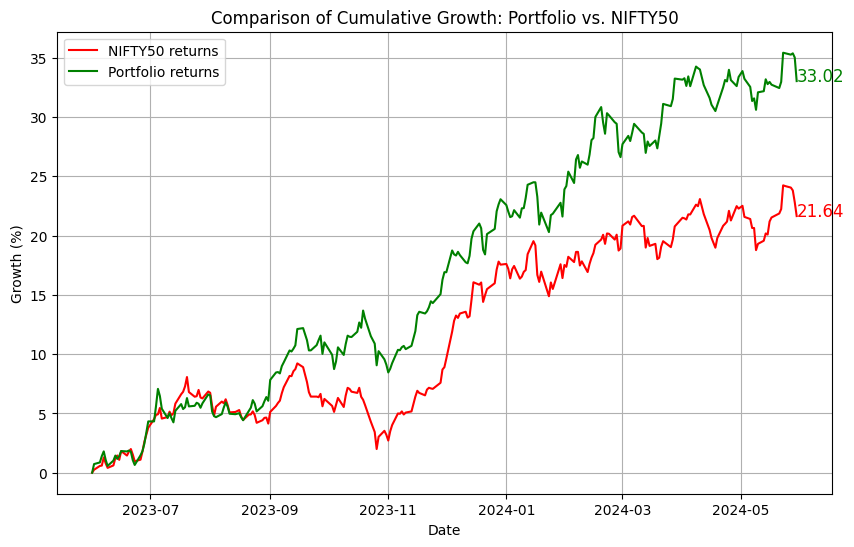

In [11]:
#Visualization of cummilative growth of NIFTY50 & Portfolio

# Define the top 50 stock tickers
stock_tickers = top_20

# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Fetch historical stock data
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stock_tickers})

# Calculate cumulative growth for Nifty50
nifty_growth = (nifty_data / nifty_data.iloc[0] - 1) * 100

# Calculate cumulative growth for the portfolio (equal-weighted)
portfolio_growth = (portfolio_data.sum(axis=1) / portfolio_data.sum(axis=1).iloc[0] - 1) * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nifty_growth, label='NIFTY50 returns', color='red')
plt.plot(portfolio_growth, label='Portfolio returns', color='green')
plt.title('Comparison of Cumulative Growth: Portfolio vs. NIFTY50')
plt.xlabel('Date')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)

# Annotate the final value of each line
plt.text(nifty_growth.index[-1], nifty_growth.iloc[-1], f'{nifty_growth.iloc[-1]:.2f}', color='red', fontsize=12, ha='left')
plt.text(portfolio_growth.index[-1], portfolio_growth.iloc[-1], f'{portfolio_growth.iloc[-1]:.2f}', color='green', fontsize=12, ha='left')

plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

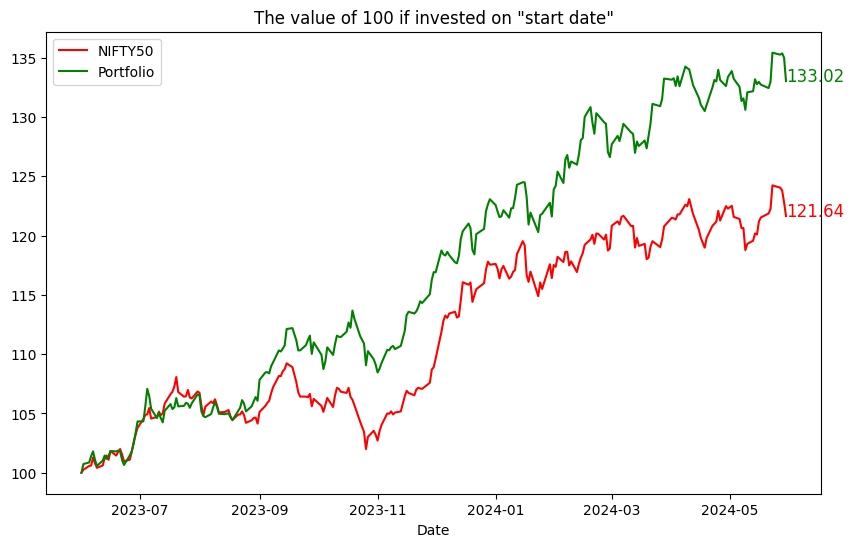

In [12]:
# Define the top 50 stock tickers
stock_tickers = top_20


# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Fetch historical stock data up to the end month
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stock_tickers})

# Calculate cumulative growth for NIFTY
nifty_growth = (nifty_data / nifty_data.iloc[0]) * 100

# Calculate cumulative growth for the portfolio (equal-weighted)
portfolio_growth = (portfolio_data.sum(axis=1) / portfolio_data.sum(axis=1).iloc[0]) * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nifty_growth, label='NIFTY50', color='red')
plt.plot(portfolio_growth, label='Portfolio', color='green')
plt.title('The value of 100 if invested on "start date"')
plt.xlabel('Date')
plt.legend()
plt.grid(False)

# Annotate the final value of each line
plt.text(nifty_growth.index[-1], nifty_growth.iloc[-1], f'{nifty_growth.iloc[-1]:.2f}', color='red', fontsize=12, ha='left')
plt.text(portfolio_growth.index[-1], portfolio_growth.iloc[-1], f'{portfolio_growth.iloc[-1]:.2f}', color='green', fontsize=12, ha='left')

plt.show()


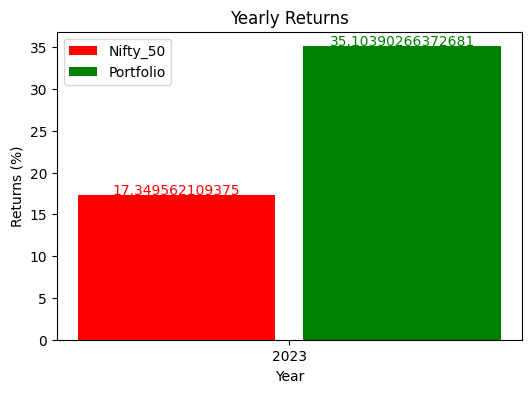

In [13]:
#Visual comparision of yearly returns between portfolio & NIFTY50

# Plotting
plt.figure(figsize=(6, 4))

# Plot Nifty_50 returns
plt.bar(y_trade_df['Year'] - 0.2, y_trade_df['Nifty_50'], width=0.35, label='Nifty_50', color='red')

# Plot Portfolio returns
plt.bar(y_trade_df['Year'] + 0.2, y_trade_df['Portfolio'], width=0.35, label='Portfolio', color='green')

plt.title('Yearly Returns')
plt.xlabel('Year')
plt.ylabel('Returns (%)')
plt.xticks(y_trade_df['Year'])
plt.legend()

# Annotate each bar with its corresponding value
for index, row in y_trade_df.iterrows():
    plt.text(row['Year'] - 0.2, row['Nifty_50'] + 0.1, str(row['Nifty_50']), color='red', ha='center')
    plt.text(row['Year'] + 0.2, row['Portfolio'] + 0.1, str(row['Portfolio']), color='green', ha='center')

plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

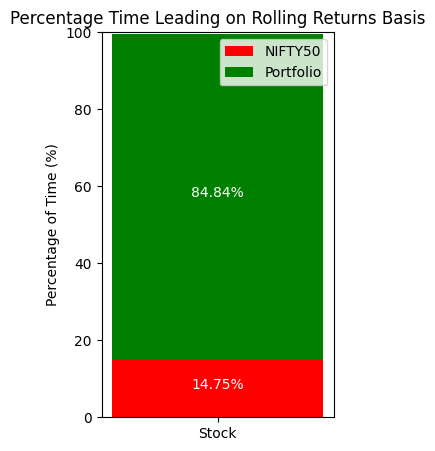

In [14]:
# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Define your portfolio stock tickers
stock_tickers = top_20

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Fetch historical stock data up to the end month
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stock_tickers})

# Align both series by their dates
nifty_data = nifty_data.loc[portfolio_data.index]

# Calculate daily returns for NIFTY50
nifty_daily_returns = nifty_data.pct_change()

# Calculate daily returns for the portfolio (equal-weighted)
portfolio_daily_returns = portfolio_data.mean(axis=1).pct_change()

# Calculate cumulative returns
nifty_cumulative_returns = (1 + nifty_daily_returns).cumprod() - 1
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod() - 1

# Align both cumulative returns series
nifty_cumulative_returns, portfolio_cumulative_returns = nifty_cumulative_returns.align(portfolio_cumulative_returns, join='inner')

# Compare cumulative returns and count occurrences
nifty_outperforms = (nifty_cumulative_returns > portfolio_cumulative_returns).sum()
portfolio_outperforms = (nifty_cumulative_returns < portfolio_cumulative_returns).sum()
total_days = len(nifty_cumulative_returns)

# Calculate the percentage of time each outperforms the other
nifty_outperforms_percentage = nifty_outperforms / total_days * 100
portfolio_outperforms_percentage = portfolio_outperforms / total_days * 100

# Plotting
plt.figure(figsize=(3, 5))

# Plot a single stacked bar chart with reduced width
plt.bar(['Stock'], nifty_outperforms_percentage, width=0.2, color='red', label='NIFTY50')
plt.bar(['Stock'], portfolio_outperforms_percentage, bottom=nifty_outperforms_percentage, width=0.2, color='green', label='Portfolio')

plt.title('Percentage Time Leading on Rolling Returns Basis')
plt.ylabel('Percentage of Time (%)')
plt.legend()

plt.text('Stock', nifty_outperforms_percentage / 2, f'{nifty_outperforms_percentage:.2f}%', color='white', ha='center')
plt.text('Stock', nifty_outperforms_percentage + portfolio_outperforms_percentage / 2, f'{portfolio_outperforms_percentage:.2f}%', color='white', ha='center')

plt.ylim(0, 100)

plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

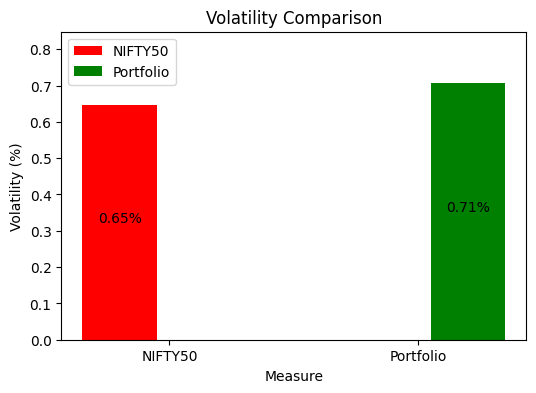

In [15]:
#Visual representation of volatility comparision between portfolio & NIFTY50

# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Fetch historical stock data up to the end month
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stock_tickers})

# Calculate daily returns for NIFTY50
nifty_daily_returns = nifty_data.pct_change()

# Calculate daily returns for the portfolio (equal-weighted)
portfolio_daily_returns = portfolio_data.mean(axis=1).pct_change()

# Calculate volatility (standard deviation) for NIFTY50
nifty_volatility = nifty_daily_returns.std() * 100  # Converting to percentage

# Calculate portfolio volatility (standard deviation)
portfolio_volatility = portfolio_daily_returns.std() * 100  # Converting to percentage

# Plotting
plt.figure(figsize=(6, 4))

# Define the x-axis positions for the bars
x = np.arange(1.5)

# Plot the volatilities in a bar graph with reduced width
plt.bar(x - 0.2, [nifty_volatility, 0], width=0.3, color='red', label='NIFTY50')
plt.bar(x + 0.2, [0, portfolio_volatility], width=0.3, color='green', label='Portfolio')

plt.title('Volatility Comparison')
plt.xlabel('Measure')
plt.ylabel('Volatility (%)')
plt.xticks(x, ['NIFTY50', 'Portfolio'])
plt.legend()

# Annotate the bars with the volatility values
plt.text(x[0] - 0.2, nifty_volatility / 2, f'{nifty_volatility:.2f}%', color='black', ha='center')
plt.text(x[1] + 0.2, portfolio_volatility / 2, f'{portfolio_volatility:.2f}%', color='black', ha='center')

plt.ylim(0, max(nifty_volatility, portfolio_volatility) * 1.2)  # Set y-axis limit to accommodate the bars

plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

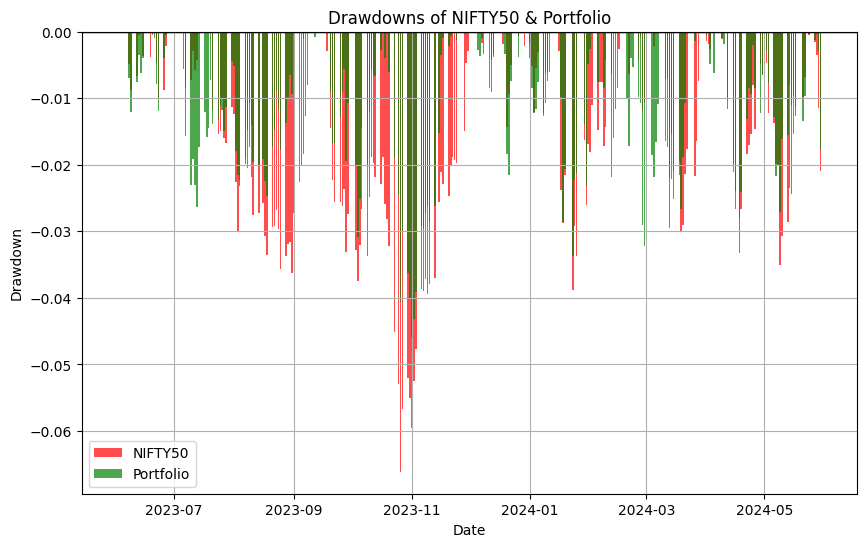

In [16]:
#Drawdown and maximum drawdown of NIFTY50 & Portfolio
# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Fetch historical stock data up to the end month
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stock_tickers})

# Calculate daily returns for NIFTY50
nifty_daily_returns = nifty_data.pct_change()

# Calculate the daily returns for the portfolio (equal-weighted)
portfolio_daily_returns = portfolio_data.mean(axis=1).pct_change()

# Calculate the cumulative product of the NIFTY50 returns
nifty_cumulative_returns = (1 + nifty_daily_returns).cumprod()

# Calculate the cumulative product of the portfolio returns
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()

# Calculate the cumulative maximum of the NIFTY50 returns
nifty_cumulative_max = nifty_cumulative_returns.cummax()

# Calculate the cumulative maximum of the portfolio returns
portfolio_cumulative_max = portfolio_cumulative_returns.cummax()

# Calculate the drawdown as the ratio of the returns to the cumulative maximum
nifty_drawdown = (nifty_cumulative_returns - nifty_cumulative_max) / nifty_cumulative_max
portfolio_drawdown = (portfolio_cumulative_returns - portfolio_cumulative_max) / portfolio_cumulative_max

# Print maximum drawdown values
print("Maximum Drawdown:")
print(f"NIFTY50: {nifty_drawdown.min() * 100:.2f}%")
print(f"Portfolio: {portfolio_drawdown.min() * 100:.2f}%")

# Plotting
plt.figure(figsize=(10, 6))

# Plot the drawdown for NIFTY50
plt.bar(nifty_drawdown.index, nifty_drawdown, color='red', alpha=0.7, label='NIFTY50')

# Plot the drawdown for the portfolio
plt.bar(portfolio_drawdown.index, portfolio_drawdown, color='green', alpha=0.7, label='Portfolio')

plt.title('Drawdowns of NIFTY50 & Portfolio')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.axhline(0, color='black', linewidth=1)  # Add a horizontal line at y=0
plt.legend()
plt.grid(True)

plt.show()


In [17]:

# Define the stock tickers and historical data range
stock_tickers = top_20

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Initialize empty dictionary to store historical stock data
stock_data = {}

# Fetch historical stock data for each stock
for ticker in stock_tickers:
    stock_data[ticker] = fetch_historical_data(ticker, start_date, end_date)

# Combine stock data into a single DataFrame
all_stock_data = pd.DataFrame(stock_data)

# Calculate portfolio returns
portfolio_returns = all_stock_data.pct_change().dropna()

# Equal weights for each stock in the portfolio
num_stocks = len(stock_tickers)
equal_weight = 1 / num_stocks

# Calculate average annual returns for each stock
average_annual_returns = portfolio_returns.mean() * 252  # 252 trading days in a year

# Calculate portfolio returns by multiplying the stock weightage to the average stock returns and summing them up
portfolio_annual_return = (average_annual_returns * equal_weight).sum()

# Risk-free rate (assuming 7%)
risk_free_rate = 0.07

# Calculate covariance matrix
covariance_matrix = portfolio_returns.cov() * 252

# Ensure covariance matrix is positive semi-definite
cholesky_factor = np.linalg.cholesky(covariance_matrix + 1e-10 * np.eye(len(covariance_matrix)))

# Calculate portfolio standard deviation
portfolio_std_dev = np.sqrt(np.dot(equal_weight, np.dot(cholesky_factor, cholesky_factor.T).diagonal()))

# Calculate market returns (assuming S&P 500 index as market)
market_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
market_returns = market_data.pct_change().dropna()

# Align market returns with portfolio returns
market_returns = market_returns[:len(portfolio_returns)]

# Calculate beta of the portfolio
portfolio_beta = np.cov(portfolio_returns.T, market_returns)[0, 1] / np.var(market_returns)

# Calculate Treynor Measure for the portfolio
treynor_measure = (portfolio_annual_return - risk_free_rate) / portfolio_beta

# Calculate Jensen's Alpha for the portfolio
portfolio_alpha = portfolio_annual_return - (risk_free_rate + portfolio_beta * (np.mean(market_returns) * 252 - risk_free_rate))

print ("Portfolio Beta:", portfolio_beta) 
print("Treynor Measure:", treynor_measure)
print("Jensen's Alpha:", portfolio_alpha)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [18]:
#Sharpe ratio
tickers = top_20
# Function to fetch historical stock data
def fetch_historical_data(stock, start, end):
    return yf.download(stock, start=start, end=end)['Adj Close']

# Function to calculate portfolio returns and Sharpe Ratio
def compute_sharpe_ratio(data, weights, risk_free_rate=0.07):
    # Combine stock data into a single DataFrame
    all_stock_data = pd.DataFrame(data)
    
    # Calculate portfolio returns
    stock_returns = all_stock_data.pct_change().dropna()
    
    # Calculate portfolio returns by multiplying the stock weightage to the average stock returns and summing them up
    portfolio_annual_return = (stock_returns.mean() * 252 @ weights)
    
    # Calculate portfolio standard deviation
    portfolio_volatility = np.sqrt(weights.T @ (stock_returns.cov() * 252) @ weights)
    
    # Calculate Sharpe Ratio for the portfolio
    sharpe_ratio = (portfolio_annual_return - risk_free_rate) / portfolio_volatility
    
    return sharpe_ratio[0]  # Return the single Sharpe Ratio value

# Fetch historical stock data for each stock
stock_prices = {}
for ticker in tickers:
    stock_prices[ticker] = fetch_historical_data(ticker, start_date, end_date)

# Equal weights for each stock in the portfolio
num_stocks = len(tickers)
weights_portfolio = np.ones((num_stocks, 1)) / num_stocks

# Calculate Sharpe Ratio of the portfolio with equal weights
sharpe_ratio_portfolio = compute_sharpe_ratio(stock_prices, weights_portfolio)

print("Sharpe Ratio:", sharpe_ratio_portfolio)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [19]:

# Function to fetch historical stock data
def fetch_historical_data(stock, start_date, end_date):
    return yf.download(stock, start=start_date, end=end_date)['Adj Close']

# Function to calculate daily returns
def calculate_daily_returns(data):
    return data.pct_change().dropna()

# Function to calculate tracking error
def calculate_tracking_error(portfolio_data, benchmark_data):
    # Calculate daily returns
    portfolio_returns = calculate_daily_returns(portfolio_data).mean(axis=1)
    benchmark_returns = calculate_daily_returns(benchmark_data)
    
    # Ensure the lengths of portfolio and benchmark returns match
    if len(portfolio_returns) != len(benchmark_returns):
        raise ValueError("Portfolio data and benchmark data must have the same length")

    # Calculate the active returns
    active_returns = portfolio_returns - benchmark_returns

    # Calculate the tracking error (standard deviation of the active returns) and annualize it
    tracking_error = np.std(active_returns) * np.sqrt(252)  # Annualized tracking error
    return tracking_error

# Function to calculate information ratio
def calculate_information_ratio(portfolio_data, benchmark_data, tracking_error):
    # Calculate annualized returns for portfolio and benchmark
    portfolio_daily_returns = calculate_daily_returns(portfolio_data).mean(axis=1)
    benchmark_daily_returns = calculate_daily_returns(benchmark_data)
    
    portfolio_annual_return = np.mean(portfolio_daily_returns) * 252
    benchmark_annual_return = np.mean(benchmark_daily_returns) * 252
    
    # Calculate the information ratio
    information_ratio = (portfolio_annual_return - benchmark_annual_return) / tracking_error
    return information_ratio

# Define the portfolio tickers and benchmark ticker
portfolio_tickers = top_20
benchmark_ticker = '^NSEI'

# Define the start and end dates
start_date = "2023-01-01"
end_date = "2024-04-25"

# Fetch historical stock data for portfolio and benchmark
portfolio_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in portfolio_tickers})
benchmark_data = fetch_historical_data(benchmark_ticker, start_date, end_date)

# Calculate tracking error
tracking_error = calculate_tracking_error(portfolio_data, benchmark_data)
print("Tracking error:", tracking_error)

# Calculate information ratio
information_ratio = calculate_information_ratio(portfolio_data, benchmark_data, tracking_error)
print("Information Ratio:", information_ratio)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [20]:
# Portfolio optimization using efficient frontier

# Define the stock tickers and historical data
e_stock_tickers = top_20
e_start_date = "2023-06-01"
e_end_date = "2024-05-31" 

# Function to fetch historical stock data
def e_fetch_historical_data(e_stock_ticker, e_start_date, e_end_date):
    return yf.download(e_stock_ticker, start= e_start_date, end= e_end_date)['Adj Close']

# Fetch historical stock data up to the end date
e_stock_data = pd.DataFrame({ticker: e_fetch_historical_data(ticker, e_start_date, e_end_date) for ticker in e_stock_tickers})

# Calculate daily returns
e_daily_returns = e_stock_data.pct_change().dropna()
print(e_daily_returns.head())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

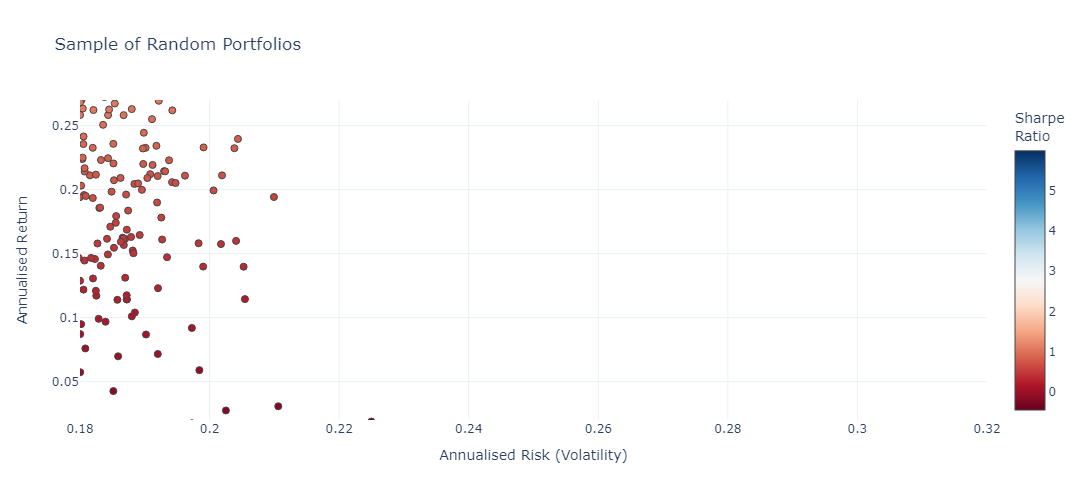

In [21]:
#-- Get annualised mean returns
mus = (1+e_daily_returns.mean())**252 - 1

#-- Get covariances
#- Multiply by 252 to annualise it (square root time for volatility but no square root for variance)
#- Note: 252 trading days in a year

cov = e_daily_returns.cov()*252

#- How many assests to include in each portfolio
n_assets = 4
#-- How many portfolios to generate
n_portfolios = 10000

#-- Initialize empty list to store mean-variance pairs for plotting
mean_variance_pairs = []

np.random.seed(75)
#-- Loop through and generate lots of random portfolios
for i in range(n_portfolios):
    #- Choose assets randomly without replacement
    assets = np.random.choice(list(e_daily_returns.columns), n_assets, replace=False)
    #- Choose weights randomly
    weights = np.random.rand(n_assets)
    #- Ensure weights sum to 1
    weights = weights/sum(weights)

    #-- Loop over asset pairs and compute portfolio return and variance
    
    portfolio_E_Variance = 0
    portfolio_E_Return = 0
    for i in range(len(assets)):
        portfolio_E_Return += weights[i] * mus.loc[assets[i]]
        for j in range(len(assets)):
            #-- Add variance/covariance for each asset pair
            #- Note that when i==j this adds the variance
            portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
            
    #-- Add the mean/variance pairs to a list for plotting
    mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])

#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0.07 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.32])
fig.update_yaxes(range=[0.02,0.27])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

100%|██████████| 10000/10000 [00:05<00:00, 1767.71it/s]


113
    Portfolio Name                                             Stocks  \
0      Portfolio 1      ICICIBANK.NS, ONGC.NS, TATACONSUM.NS, INFY.NS   
1      Portfolio 2   LICI.NS, EICHERMOT.NS, BAJAJ-AUTO.NS, HCLTECH.NS   
2      Portfolio 3    COALINDIA.NS, LICI.NS, HCLTECH.NS, ICICIBANK.NS   
3      Portfolio 4    ONGC.NS, HCLTECH.NS, TATASTEEL.NS, EICHERMOT.NS   
4      Portfolio 5      GAIL.NS, ICICIBANK.NS, HEROMOTOCO.NS, ONGC.NS   
..             ...                                                ...   
108  Portfolio 109   COALINDIA.NS, HEROMOTOCO.NS, HCLTECH.NS, GAIL.NS   
109  Portfolio 110  BAJAJ-AUTO.NS, MARUTI.NS, DRREDDY.NS, COALINDI...   
110  Portfolio 111   BAJAJ-AUTO.NS, COALINDIA.NS, DRREDDY.NS, LTIM.NS   
111  Portfolio 112  HCLTECH.NS, ICICIBANK.NS, MARUTI.NS, TATACONSU...   
112  Portfolio 113   COALINDIA.NS, GAIL.NS, BAJAJ-AUTO.NS, HCLTECH.NS   

                    Weights  
0    0.25, 0.30, 0.21, 0.24  
1    0.31, 0.30, 0.24, 0.15  
2    0.09, 0.27, 0.26, 0.37  

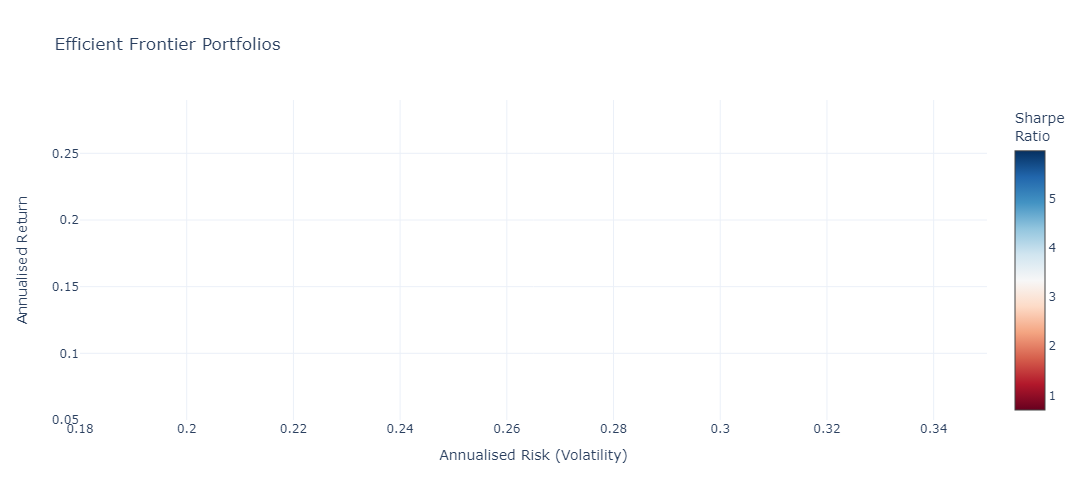

In [22]:
#-- Create random portfolio weights and indexes
#- How many assests in the portfolio
n_assets = 4

mean_variance_pairs = []
weights_list=[]
tickers_list=[]

for i in tqdm(range(10000)):
    next_i = False
    while True:
        #- Choose assets randomly without replacement
        assets = np.random.choice(list(e_daily_returns.columns), n_assets, replace=False)
        #- Choose weights randomly ensuring they sum to one
        weights = np.random.rand(n_assets)
        weights = weights/sum(weights)

        #-- Loop over asset pairs and compute portfolio return and variance
        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]

        #-- Skip over dominated portfolios
        for R,V in mean_variance_pairs:
            if (R > portfolio_E_Return) & (V < portfolio_E_Variance):
                next_i = True
                break
        if next_i:
            break

        #-- Add the mean/variance pairs to a list for plotting
        mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])
        weights_list.append(weights)
        tickers_list.append(assets)
        break

print (len(mean_variance_pairs))

# Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate = 0.07

# Create lists to store portfolio information
stocks_in_portfolios = []
weights_in_portfolios = []
portfolio_names = []  # List to store portfolio names

# Iterate through each portfolio
for i in range(len(tickers_list)):
    # Extract stocks and their weightage for the portfolio
    assets = tickers_list[i]
    weights = weights_list[i]
    
    # Append to the lists
    stocks_in_portfolios.append(", ".join([asset.split(":")[0] for asset in assets]))  # Extracting only the stock names
    weights_in_portfolios.append(", ".join([f"{weight:.2f}" for weight in weights]))  # Extracting only the weights
    portfolio_names.append(f'Portfolio {i+1}')  # Assigning portfolio names

# Create DataFrame from the collected portfolio data
portfolio_df = pd.DataFrame({'Portfolio Name': portfolio_names,
                             'Stocks': stocks_in_portfolios,
                             'Weights': weights_in_portfolios})

# Print portfolio information
print(portfolio_df)

# Create the figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[f"{portfolio_names[i]}<br>{str(np.array(tickers_list[i]))}<br>{str(np.array(weights_list[i]).round(2))}" for i in range(len(tickers_list))]))  # Add portfolio names to text
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Efficient Frontier Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.35])
fig.update_yaxes(range=[0.05,0.29])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

# Show the figure
fig.show()


In [ ]:

# Define start and end dates for future returns calculation
start_date = "2024-01-01"
end_date = "2024-05-31"

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Function to calculate portfolio return
def calculate_portfolio_return(row):
    # Extract stocks and their weights
    assets = row['Stocks'].split(", ")
    weights = [float(w) for w in row['Weights'].split(", ")]
    
    # Fetch historical stock data for the specified time period
    historical_stock_data = pd.DataFrame({ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in assets})
    
    # Calculate daily returns for each stock
    daily_returns = historical_stock_data.pct_change().dropna()
    
    # Initialize an array to store portfolio returns
    portfolio_returns = []
    
    # Calculate portfolio return for each day
    for i in range(len(daily_returns)):
        # Calculate weighted daily returns for each stock
        weighted_daily_returns = daily_returns.iloc[i] * weights
        
        # Calculate portfolio daily return by summing up weighted returns
        portfolio_daily_return = weighted_daily_returns.sum()
        
        # Append portfolio return to the array
        portfolio_returns.append(portfolio_daily_return)
    
    # Convert the list of portfolio returns to a pandas Series
    portfolio_returns_series = pd.Series(portfolio_returns)
    
    # Calculate cumulative return for the period
    cumulative_return = (1 + portfolio_returns_series).prod() - 1
    
    return cumulative_return

# Apply the function to each row in the DataFrame and store the results in a new column
portfolio_df['Portfolio Return'] = portfolio_df.apply(calculate_portfolio_return, axis=1)

# Print portfolio returns
print(portfolio_df[['Stocks', 'Weights', 'Portfolio Return']])

# Define the file path for saving the CSV file
output_file_path = "ERP5_portfolio_returns.csv"

# Save the DataFrame to a CSV file
portfolio_df.to_csv(output_file_path, index=False)

print("Portfolio returns saved to:", output_file_path)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


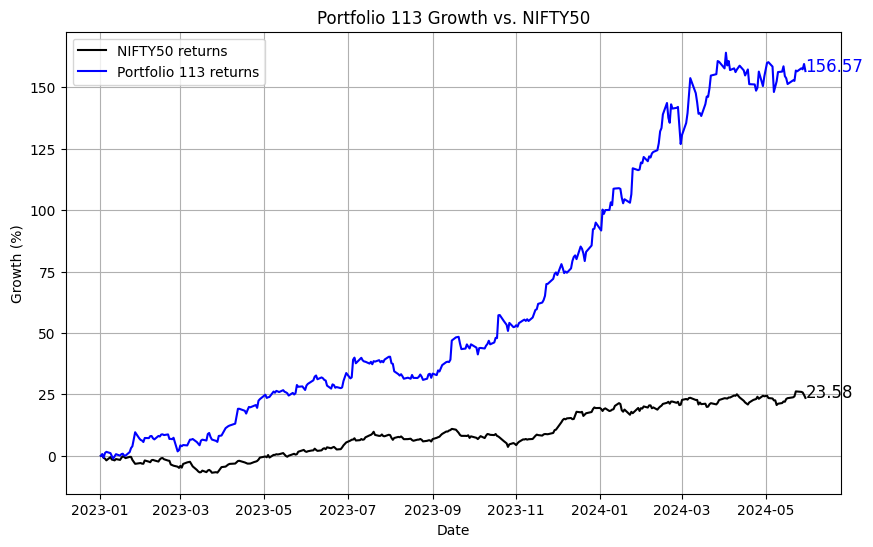

In [31]:

# Define start and end dates
start_date = "2023-01-01"
end_date = "2024-05-31"

# Fetch stock data for Nifty50
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Function to fetch historical stock data
def fetch_historical_data(stock_ticker, start_date, end_date):
    return yf.download(stock_ticker, start=start_date, end=end_date)['Adj Close']

# Function to plot portfolio growth
def plot_portfolio_growth(portfolio_name):
    # Fetch historical stock data for portfolio stocks
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    assets = portfolio_row['Stocks'].iloc[0].split(", ")
    
    # Fetch historical data for each stock in the portfolio
    stock_data = {}
    for asset in assets:
        stock_data[asset] = fetch_historical_data(asset, start_date, end_date)
    
    # Combine historical data for all stocks in the portfolio
    portfolio_data = pd.DataFrame(stock_data)
    
    # Calculate portfolio growth
    portfolio_growth = (portfolio_data.mul(weights, axis=1).sum(axis=1) / portfolio_data.mul(weights, axis=1).sum(axis=1).iloc[0] - 1) * 100
    
    # Calculate cumulative growth for Nifty50
    nifty_growth = (nifty_data / nifty_data.iloc[0] - 1) * 100

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(nifty_growth, label='NIFTY50 returns', color='black')
    plt.plot(portfolio_growth, label=f'{portfolio_name} returns', color='blue')

    # Annotate the final value of each line
    final_nifty_return = nifty_growth.iloc[-1]
    final_portfolio_return = portfolio_growth.iloc[-1]
    plt.text(nifty_growth.index[-1], final_nifty_return, f'{final_nifty_return:.2f}', color='black', fontsize=12, ha='left')
    plt.text(portfolio_growth.index[-1], final_portfolio_return, f'{final_portfolio_return:.2f}', color='blue', fontsize=12, ha='left')

    plt.title(f'{portfolio_name} Growth vs. NIFTY50')
    plt.xlabel('Date')
    plt.ylabel('Growth (%)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Enter the portfolio number
plot_portfolio_growth('Portfolio 113')


Enter the name of the portfolio:  Portfolio 113


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


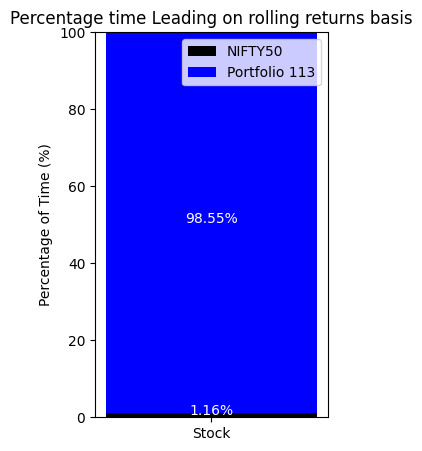

In [32]:

# Define start and end dates
start_date = "2023-01-01"
end_date = "2024-05-31"

# Function to fetch historical stock data
def fetch_historical_data(stock_tickers, start_date, end_date):
    return pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in stock_tickers})

# Function to calculate cumulative returns
def calculate_cumulative_returns(data, weights):
    cumulative_returns = (data.mul(weights, axis=1).sum(axis=1) / data.mul(weights, axis=1).sum(axis=1).iloc[0] - 1) * 100
    return cumulative_returns

# Function to plot percentage time leading
def plot_percentage_time_leading(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Fetch historical stock data for portfolio stocks
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    portfolio_data = fetch_historical_data(stocks, start_date, end_date)
    
    # Calculate cumulative returns for the portfolio
    portfolio_cumulative_returns = calculate_cumulative_returns(portfolio_data, weights)
    
    # Calculate daily returns for NIFTY50
    nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
    nifty_daily_returns = nifty_data.pct_change()
    
    # Calculate cumulative returns for NIFTY50
    nifty_cumulative_returns = (1 + nifty_daily_returns).cumprod() - 1
    
    # Compare cumulative returns and count occurrences
    nifty_outperforms = (nifty_cumulative_returns > portfolio_cumulative_returns).sum()
    portfolio_outperforms = (nifty_cumulative_returns < portfolio_cumulative_returns).sum()
    total_days = len(nifty_cumulative_returns)
    
    # Calculate the percentage of time each outperforms the other
    nifty_outperforms_percentage = nifty_outperforms / total_days * 100
    portfolio_outperforms_percentage = portfolio_outperforms / total_days * 100
    
    # Plotting
    plt.figure(figsize=(3, 5))
    
    # Plot a single stacked bar chart with reduced width
    plt.bar(['Stock'], nifty_outperforms_percentage, width=0.2, color='black', label='NIFTY50')
    plt.bar(['Stock'], portfolio_outperforms_percentage, bottom=nifty_outperforms_percentage, width=0.2, color='blue', label= f'{portfolio_name}')
    
    plt.title('Percentage time Leading on rolling returns basis')
    plt.ylabel('Percentage of Time (%)')
    plt.legend()
    
    plt.text('Stock', nifty_outperforms_percentage / 2, f'{nifty_outperforms_percentage:.2f}%', color='white', ha='center')
    plt.text('Stock', nifty_outperforms_percentage + portfolio_outperforms_percentage / 2, f'{portfolio_outperforms_percentage:.2f}%', color='white', ha='center')
    
    plt.ylim(0, 100)
    
    plt.show()

# Enter the portfolio number
portfolio_name = input("Enter the name of the portfolio: ")
plot_percentage_time_leading(portfolio_name)


Enter the name of the portfolio:  Portfolio 113


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


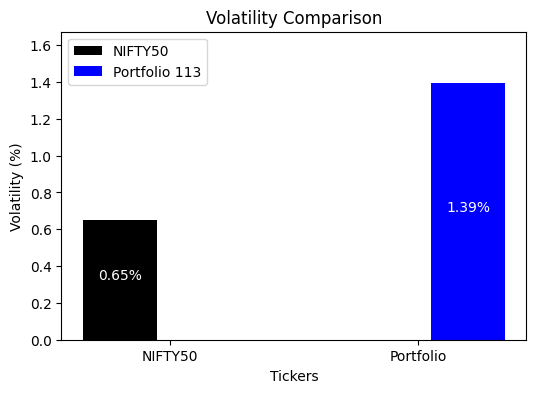

In [33]:

# Define start and end dates
start_date = "2023-01-01"
end_date = "2024-05-31"

# Function to fetch historical stock data
def fetch_historical_data(stock_tickers, start_date, end_date):
    return pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in stock_tickers})

# Function to calculate daily returns
def calculate_daily_returns(data, weights):
    return (data.mul(weights, axis=1).sum(axis=1)).pct_change()

# Function to calculate volatility (standard deviation)
def calculate_volatility(daily_returns):
    return daily_returns.std() * 100  # Converting to percentage

# Function to plot volatility comparison
def plot_volatility_comparison(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Fetch historical stock data for portfolio stocks
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    portfolio_data = fetch_historical_data(stocks, start_date, end_date)
    
    # Calculate daily returns for NIFTY50
    nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
    nifty_daily_returns = nifty_data.pct_change()
    
    # Calculate daily returns for the portfolio
    portfolio_daily_returns = calculate_daily_returns(portfolio_data, weights)
    
    # Calculate volatility for NIFTY50
    nifty_volatility = calculate_volatility(nifty_daily_returns)
    
    # Calculate volatility for the portfolio
    portfolio_volatility = calculate_volatility(portfolio_daily_returns)
    
    # Plotting
    plt.figure(figsize=(6, 4))
    
    # Define the x-axis positions for the bars
    x = np.arange(1.5)
    
    # Plot the volatilities in a bar graph with reduced width
    plt.bar(x - 0.2, [nifty_volatility, 0], width=0.3, color='black', label='NIFTY50')
    plt.bar(x + 0.2, [0, portfolio_volatility], width=0.3, color='blue', label= f'{portfolio_name}')
    
    plt.title('Volatility Comparison')
    plt.xlabel('Tickers')
    plt.ylabel('Volatility (%)')
    plt.xticks(x, ['NIFTY50', 'Portfolio'])
    plt.legend()
    
    # Annotate the bars with the volatility values
    plt.text(x[0] - 0.2, nifty_volatility / 2, f'{nifty_volatility:.2f}%', color='white', ha='center')
    plt.text(x[1] + 0.2, portfolio_volatility / 2, f'{portfolio_volatility:.2f}%', color='white', ha='center')
    
    plt.ylim(0, max(nifty_volatility, portfolio_volatility) * 1.2)  # Set y-axis limit to accommodate the bars
    
    plt.show()

# Enter the portfolio number:
portfolio_name = input("Enter the name of the portfolio: ")
plot_volatility_comparison(portfolio_name)


Enter the name of the portfolio:  Portfolio 113


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Maximum Drawdown:
NIFTY50: -7.06%
Portfolio: -7.10%


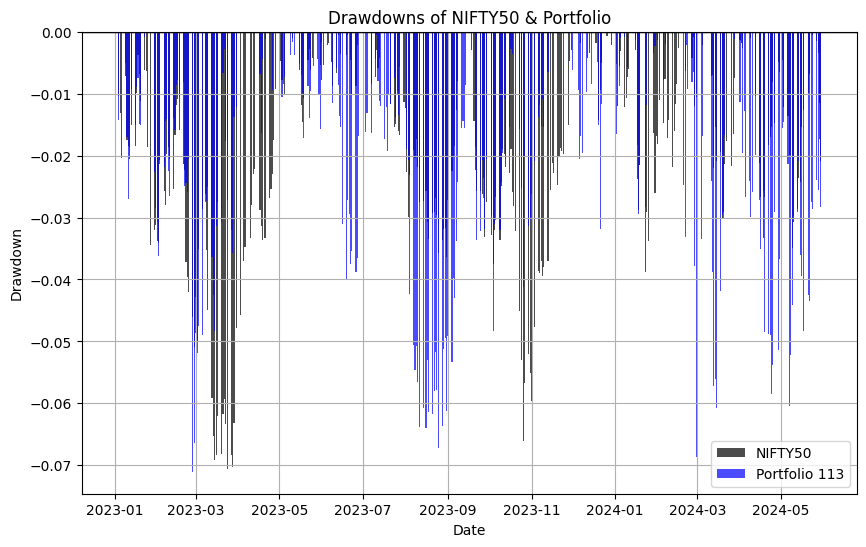

In [34]:

# Function to fetch historical stock data
def fetch_historical_data(stock_tickers, start_date, end_date):
    return pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in stock_tickers})

# Function to calculate daily returns
def calculate_daily_returns(data, weights):
    return (data.mul(weights, axis=1).sum(axis=1)).pct_change()

# Function to calculate drawdown
def calculate_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    return drawdown

# Function to plot drawdown
def plot_drawdown(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Fetch historical stock data for portfolio stocks
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    portfolio_data = fetch_historical_data(stocks, start_date, end_date)
    
    # Calculate daily returns for NIFTY50
    nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
    nifty_daily_returns = nifty_data.pct_change()
    
    # Calculate daily returns for the portfolio
    portfolio_daily_returns = calculate_daily_returns(portfolio_data, weights)
    
    # Calculate cumulative returns
    nifty_cumulative_returns = (1 + nifty_daily_returns).cumprod()
    portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()
    
    # Calculate drawdown
    nifty_drawdown = calculate_drawdown(nifty_cumulative_returns)
    portfolio_drawdown = calculate_drawdown(portfolio_cumulative_returns)
    
    # Print maximum drawdown values
    print("Maximum Drawdown:")
    print(f"NIFTY50: {nifty_drawdown.min() * 100:.2f}%")
    print(f"Portfolio: {portfolio_drawdown.min() * 100:.2f}%")
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot the drawdown for NIFTY
    plt.bar(nifty_drawdown.index, nifty_drawdown, color='black', alpha=0.7, label='NIFTY50')
    
    # Plot the drawdown for the portfolio
    plt.bar(portfolio_drawdown.index, portfolio_drawdown, color='blue', alpha=0.7, label= f'{portfolio_name}')
    
    plt.title('Drawdowns of NIFTY50 & Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.axhline(0, color='black', linewidth=1)  # Add a horizontal line at y=0
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Enter the portfolio number:
portfolio_name = input("Enter the name of the portfolio: ")
plot_drawdown(portfolio_name)


In [35]:
# Define the historical data range
start_date = "2023-01-01"
end_date = "2024-05-31"

# Function to fetch historical stock data
def fetch_historical_data(stock_tickers, start_date, end_date):
    stock_data = {}
    for ticker in stock_tickers:
        stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    return pd.DataFrame(stock_data)

# Function to calculate portfolio returns
def calculate_portfolio_returns(stock_data, weights):
    portfolio_returns = stock_data.pct_change().dropna()
    portfolio_returns = (portfolio_returns * weights).sum(axis=1)
    return portfolio_returns

# Function to calculate portfolio statistics
def calculate_portfolio_statistics(portfolio_returns):
    # Calculate cumulative return for the period
    cumulative_return = (1 + portfolio_returns).prod() - 1
    
    # Annualize cumulative return
    portfolio_annual_return = (1 + cumulative_return) ** (252 / len(portfolio_returns)) - 1
    
    # Calculate standard deviation
    portfolio_std_dev = portfolio_returns.std() * np.sqrt(252)
    
    # Risk-free rate (assuming 7%)
    risk_free_rate = 0.07
    
    # Calculate market returns
    market_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
    market_returns = market_data.pct_change().dropna()
    
    # Align market returns with portfolio returns
    market_returns = market_returns[:len(portfolio_returns)]
    
    # Calculate beta of the portfolio
    cov_matrix = np.cov(portfolio_returns, market_returns)
    portfolio_beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    
    # Calculate Treynor Measure for the portfolio
    treynor_measure = (portfolio_annual_return - risk_free_rate) / portfolio_beta
    
    # Calculate Jensen's Alpha for the portfolio
    expected_return_market = np.mean(market_returns) * 252
    portfolio_alpha = portfolio_annual_return - (risk_free_rate + portfolio_beta * (expected_return_market - risk_free_rate))
    
    return portfolio_annual_return, portfolio_std_dev, portfolio_beta, treynor_measure, portfolio_alpha

# Function to analyze portfolio
def analyze_portfolio(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Extract stocks and weights for the portfolio
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    
    # Fetch historical stock data for portfolio stocks
    stock_data = fetch_historical_data(stocks, start_date, end_date)
    
    # Calculate portfolio returns
    portfolio_returns = calculate_portfolio_returns(stock_data, weights)
    
    # Calculate portfolio statistics
    portfolio_annual_return, portfolio_std_dev, portfolio_beta, treynor_measure, portfolio_alpha = calculate_portfolio_statistics(portfolio_returns)
    
    # Print portfolio statistics
    print("Portfolio Name:", portfolio_name)
    print("Portfolio Annual Return:", portfolio_annual_return)
    print("Portfolio Standard Deviation:", portfolio_std_dev)
    print("Portfolio Beta:", portfolio_beta)
    print("Treynor Measure:", treynor_measure)
    print("Jensen's Alpha:", portfolio_alpha)

# Example usage:
portfolio_name = input("Enter the name of the portfolio: ")
analyze_portfolio(portfolio_name)


Enter the name of the portfolio:  Portfolio 113


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Portfolio Name: Portfolio 113
Portfolio Annual Return: 0.9416375127102821
Portfolio Standard Deviation: 0.17708037358990888
Portfolio Beta: 0.8079482551310857
Treynor Measure: 1.0788283868115576
Jensen's Alpha: 0.7985351669243828


In [36]:

# Define the historical data range
start_date = "2023-01-01"
end_date = "2024-05-31"

# Function to fetch historical stock data
def fetch_historical_data(stock, start, end):
    return yf.download(stock, start=start, end=end)['Adj Close']

# Function to calculate portfolio returns and Sharpe Ratio
def compute_sharpe_ratio(data, weights, risk_free_rate=0.07):
    # Combine stock data into a single DataFrame
    all_stock_data = pd.DataFrame(data)
    
    # Calculate portfolio returns
    stock_returns = all_stock_data.pct_change().dropna()
    
    # Calculate portfolio returns by multiplying the stock weightage to the average stock returns and summing them up
    portfolio_annual_return = (stock_returns.mean() * 252 @ weights)
    
    # Calculate portfolio standard deviation
    portfolio_volatility = np.sqrt(weights.T @ (stock_returns.cov() * 252) @ weights)
    
    # Calculate Sharpe Ratio for the portfolio
    sharpe_ratio = (portfolio_annual_return - risk_free_rate) / portfolio_volatility
    
    return sharpe_ratio[0]  # Return the single Sharpe Ratio value

# Function to analyze portfolio
def analyze_portfolio(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Extract stocks and weights for the portfolio
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    
    # Fetch historical stock data for portfolio stocks
    stock_data = {ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stocks}
    
    # Calculate Sharpe Ratio of the portfolio
    sharpe_ratio_portfolio = compute_sharpe_ratio(stock_data, np.array(weights)[:, np.newaxis])

    print("Portfolio Name:", portfolio_name)
    print("Sharpe Ratio:", sharpe_ratio_portfolio)

# Enter the portfolio number:
portfolio_name = input("Enter the name of the portfolio: ")
analyze_portfolio(portfolio_name)


Enter the name of the portfolio:  Portfolio 113


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Portfolio Name: Portfolio 113
Sharpe Ratio: 0    3.444846
Name: 0, dtype: float64


In [37]:

# Define the historical data range
start_date = "2023-01-01"
end_date = "2024-05-31"

# Function to fetch historical stock data
def fetch_historical_data(stock, start_date, end_date):
    return yf.download(stock, start=start_date, end=end_date)['Adj Close']

# Function to calculate annualized returns
def calculate_annualized_returns(data):
    # Calculate daily returns
    daily_returns = data.pct_change().dropna()
    
    # Calculate cumulative returns
    cumulative_returns = (1 + daily_returns).prod() - 1
    
    # Annualize returns
    annualized_returns = (1 + cumulative_returns) ** (252 / len(data)) - 1  # Assuming 252 trading days in a year
    
    return annualized_returns

# Function to calculate tracking error
def calculate_tracking_error(portfolio_data, benchmark_data):
    # Ensure the lengths of portfolio and benchmark returns match
    if len(portfolio_data) != len(benchmark_data):
        raise ValueError("Portfolio data and benchmark data must have the same length")
    
    # Calculate portfolio returns and benchmark returns
    portfolio_returns = calculate_annualized_returns(portfolio_data)
    benchmark_returns = calculate_annualized_returns(benchmark_data)
    
    # Calculate the difference between portfolio returns and benchmark returns
    tracking_error = portfolio_returns - benchmark_returns
    
    # Calculate the squared tracking error
    squared_tracking_error = tracking_error ** 2
    
    # Calculate the sum of squared tracking errors
    sum_squared_tracking_error = np.sum(squared_tracking_error)
    
    # Calculate the mean squared tracking error
    mean_squared_tracking_error = sum_squared_tracking_error / (len(portfolio_returns) - 1)
    
    # Calculate the tracking error (standard deviation of the difference in returns)
    tracking_error = np.sqrt(mean_squared_tracking_error)
    
    return tracking_error

# Function to calculate information ratio for the entire portfolio
def calculate_portfolio_information_ratio(portfolio_data, benchmark_data, tracking_error):
    # Calculate annualized returns for portfolio and benchmark
    portfolio_returns = calculate_annualized_returns(portfolio_data)
    benchmark_returns = calculate_annualized_returns(benchmark_data)
    
    # Calculate weighted average portfolio return
    portfolio_weighted_return = (portfolio_returns.values * weights[:, np.newaxis]).sum()
    
    # Calculate information ratio for the entire portfolio
    information_ratio = (portfolio_weighted_return - benchmark_returns) / tracking_error
    
    return information_ratio

# Function to analyze portfolio
def analyze_portfolio(portfolio_name):
    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
        return
    
    # Extract stocks and weights for the portfolio
    stocks = portfolio_row['Stocks'].iloc[0].split(", ")
    weights = [float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")]
    
    # Fetch historical stock data for portfolio stocks
    stock_data = {ticker: fetch_historical_data(ticker, start_date, end_date) for ticker in stocks}
    
    # Fetch historical stock data for benchmark
    benchmark_data = fetch_historical_data('^NSEI', start_date, end_date)
    
    # Calculate tracking error
    tracking_error = calculate_tracking_error(pd.DataFrame(stock_data), benchmark_data)
    
    # Calculate information ratio for the entire portfolio
    portfolio_information_ratio = calculate_portfolio_information_ratio(pd.DataFrame(stock_data), benchmark_data, tracking_error)
    
    print("Portfolio Name:", portfolio_name)
    print("Information Ratio:", portfolio_information_ratio)
    print("Tracking Error:", tracking_error)

# Enter the portfolio details
portfolio_name = input("Enter the name of the portfolio: ")
analyze_portfolio(portfolio_name)


Enter the name of the portfolio:  Portfolio 113


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Portfolio Name: Portfolio 113
Information Ratio: 3.7827322734211846
Tracking Error: 0.7273157259987237


In [38]:
#Value at Risk (VaR) of the portfolio

def get_historical_returns(tickers, start_date, end_date):
    """
    Fetch historical price data for the specified tickers and calculate daily returns.
    
    Args:
    - tickers: List of ticker symbols for the assets in the portfolio
    - start_date: Start date for historical data (YYYY-MM-DD)
    - end_date: End date for historical data (YYYY-MM-DD)
    
    Returns:
    - returns: DataFrame containing daily returns for each asset
    """
    price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    daily_returns = price_data.pct_change().dropna()
    return daily_returns

def calculate_portfolio_var(daily_returns, weights, confidence_level):
    """
    Calculate Value at Risk (VaR) of a portfolio using historical simulation.
    
    Args:
    - daily_returns: DataFrame containing daily returns for each asset
    - weights: Array-like object containing the weights of individual assets in the portfolio
    - confidence_level: Desired confidence level (e.g., 0.95 for 95% confidence)
    
    Returns:
    - var: Value at Risk of the portfolio
    """
    # Calculate portfolio daily returns
    portfolio_returns = daily_returns.dot(weights)
    
    # Calculate VaR
    var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    
    return var

if __name__ == "__main__":
    
    
    portfolio_name = input("Enter the name of the portfolio: ")
    start_date = input("Enter start date for historical data (YYYY-MM-DD): ")
    end_date = input("Enter end date for historical data (YYYY-MM-DD): ")
    confidence_level = float(input("Enter confidence level (e.g., 0.95 for 95% confidence): "))

    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
    else:
        # Extract stocks and weights for the portfolio
        tickers = portfolio_row['Stocks'].iloc[0].split(", ")
        weights = np.array([float(w) for w in portfolio_row['Weights'].iloc[0].split(", ")])
        
        # Fetch historical returns
        daily_returns = get_historical_returns(tickers, start_date, end_date)
        
        # Calculate VaR of the portfolio
        portfolio_var = calculate_portfolio_var(daily_returns, weights, confidence_level)
        
        # Output results
        print(f"Value at Risk (VaR) of the portfolio at {confidence_level*100}% confidence level: {portfolio_var*100}%")


Enter the name of the portfolio:  Portfolio 113
Enter start date for historical data (YYYY-MM-DD):  2023-01-01
Enter end date for historical data (YYYY-MM-DD):  2024-05-31
Enter confidence level (e.g., 0.95 for 95% confidence):  0.99


[*********************100%%**********************]  4 of 4 completed
Value at Risk (VaR) of the portfolio at 99.0% confidence level: -2.72544188173296%


Enter the name of the portfolio:  Portfolio 113
Enter start date for historical data (YYYY-MM-DD):  2023-01-01
Enter end date for historical data (YYYY-MM-DD):  2024-05-31


[*********************100%%**********************]  4 of 4 completed


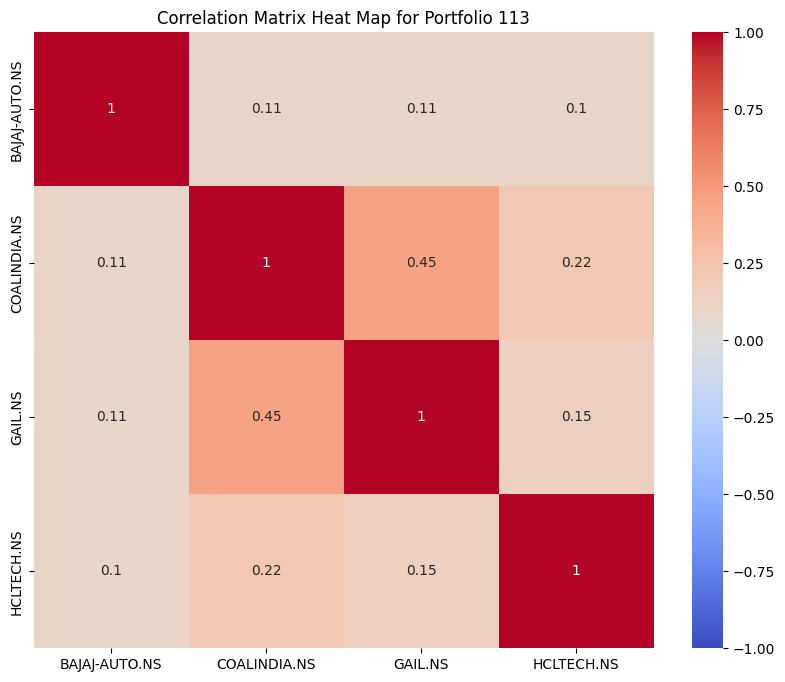

In [40]:
#Heat map for co-relation matrix of stocks in the portfolio  
def get_historical_data(tickers, start_date, end_date):
    """
    Fetch historical price data for the specified tickers.
    
    Args:
    - tickers: List of ticker symbols for the assets in the portfolio
    - start_date: Start date for historical data (YYYY-MM-DD)
    - end_date: End date for historical data (YYYY-MM-DD)
    
    Returns:
    - price_data: DataFrame containing historical price data for each asset
    """
    price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return price_data

def calculate_correlation_matrix(price_data):
    """
    Calculate the correlation matrix for the given price data.
    
    Args:
    - price_data: DataFrame containing historical price data for each asset
    
    Returns:
    - correlation_matrix: DataFrame containing the correlation matrix
    """
    correlation_matrix = price_data.pct_change().dropna().corr()
    return correlation_matrix

def plot_correlation_heatmap(correlation_matrix, portfolio_name):
    """
    Plot a heat map for the given correlation matrix.
    
    Args:
    - correlation_matrix: DataFrame containing the correlation matrix
    - portfolio_name: Name of the portfolio
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Matrix Heat Map for {portfolio_name}')
    plt.show()

if __name__ == "__main__":
    
    portfolio_name = input("Enter the name of the portfolio: ")
    start_date = input("Enter start date for historical data (YYYY-MM-DD): ")
    end_date = input("Enter end date for historical data (YYYY-MM-DD): ")

    # Find portfolio row
    portfolio_row = portfolio_df[portfolio_df['Portfolio Name'].str.lower() == portfolio_name.lower()]
    if portfolio_row.empty:
        print(f"No portfolio named '{portfolio_name}' found.")
    else:
        # Extract stocks for the portfolio
        tickers = portfolio_row['Stocks'].iloc[0].split(", ")
        
        # Fetch historical price data
        price_data = get_historical_data(tickers, start_date, end_date)
        
        # Calculate correlation matrix
        correlation_matrix = calculate_correlation_matrix(price_data)
        
        # Plot correlation matrix heat map
        plot_correlation_heatmap(correlation_matrix, portfolio_name)
